<a href="https://colab.research.google.com/github/Victor-Manach/numerai/blob/main/tabnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from dataclasses import dataclass
import math

In [2]:
def print_trainable_parameters(model):
    n_params = sum(p.numel() for p in model.parameters())
    n_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[{model.__class__.__name__}] Number of trainable parameters: {n_params_trainable:,} out of {n_params:,} total parameters.")

In [3]:
def make_ix_like_input(input, dim=0):
    d = input.size(dim)
    rho = torch.arange(1, d + 1, device=input.device, dtype=input.dtype)
    view = [1] * input.dim()
    view[0] = -1
    return rho.view(view).transpose(0, dim)

class SparsemaxFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, dim=-1):
        ctx.dim = dim
        max_val, _ = input.max(dim=dim, keepdim=True)
        stable_input = input - max_val
        tau, support_size = SparsemaxFn.threshold_and_support(stable_input, dim=dim)

        p = torch.clamp(stable_input - tau, min=0)
        ctx.save_for_backward(support_size, p)

        return p

    @staticmethod
    def backward(ctx, grad_output):
        dim = ctx.dim
        support_size, p = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[p == 0] = 0

        v_hat = grad_input.sum(dim=dim) / support_size.to(p.dtype).squeeze()
        v_hat = v_hat.unsqueeze(dim)

        grad_input = torch.where(p != 0, grad_input - v_hat, grad_input)

        return grad_input, None

    @staticmethod
    def threshold_and_support(input, dim):
        sinput, _ = torch.sort(input, dim=dim, descending=True)
        partial_sums = torch.cumsum(sinput, dim=dim) - 1

        rhos = make_ix_like_input(input, dim=dim)
        support = (rhos * sinput > partial_sums).float()

        support_size = support.sum(dim=dim, keepdim=True)
        tau = partial_sums.gather(dim, support_size.long() - 1) / support_size.to(input.dtype)

        return tau, support_size


class Sparsemax(nn.Module):
    def __init__(self, dim=-1):
        super().__init__()
        self.dim = dim

    def forward(self, input):
        return SparsemaxFn.apply(input, self.dim)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
sparsemax = Sparsemax()

In [6]:
t = torch.linspace(-3, 3, 100, device=device, dtype=torch.float32)
input = torch.stack([t, torch.zeros_like(t)], dim=1)

In [7]:
o_soft = torch.softmax(input, dim=1)[:,0]
o_soft

tensor([0.0474, 0.0502, 0.0532, 0.0563, 0.0597, 0.0632, 0.0668, 0.0707, 0.0748,
        0.0791, 0.0836, 0.0884, 0.0934, 0.0987, 0.1042, 0.1100, 0.1161, 0.1224,
        0.1291, 0.1361, 0.1433, 0.1509, 0.1589, 0.1671, 0.1757, 0.1847, 0.1940,
        0.2036, 0.2137, 0.2240, 0.2347, 0.2458, 0.2572, 0.2689, 0.2810, 0.2934,
        0.3061, 0.3192, 0.3325, 0.3461, 0.3599, 0.3740, 0.3883, 0.4028, 0.4174,
        0.4322, 0.4472, 0.4622, 0.4773, 0.4924, 0.5076, 0.5227, 0.5378, 0.5528,
        0.5678, 0.5826, 0.5972, 0.6117, 0.6260, 0.6401, 0.6539, 0.6675, 0.6808,
        0.6939, 0.7066, 0.7190, 0.7311, 0.7428, 0.7542, 0.7653, 0.7760, 0.7863,
        0.7964, 0.8060, 0.8153, 0.8243, 0.8329, 0.8411, 0.8491, 0.8567, 0.8639,
        0.8709, 0.8776, 0.8839, 0.8900, 0.8958, 0.9013, 0.9066, 0.9116, 0.9164,
        0.9209, 0.9252, 0.9293, 0.9332, 0.9368, 0.9403, 0.9437, 0.9468, 0.9498,
        0.9526])

In [8]:
o_sparse = sparsemax(input)[:,0]
o_sparse

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.9605e-08, 3.0303e-02, 6.0606e-02,
        9.0909e-02, 1.2121e-01, 1.5152e-01, 1.8182e-01, 2.1212e-01, 2.4242e-01,
        2.7273e-01, 3.0303e-01, 3.3333e-01, 3.6364e-01, 3.9394e-01, 4.2424e-01,
        4.5455e-01, 4.8485e-01, 5.1515e-01, 5.4545e-01, 5.7576e-01, 6.0606e-01,
        6.3636e-01, 6.6667e-01, 6.9697e-01, 7.2727e-01, 7.5758e-01, 7.8788e-01,
        8.1818e-01, 8.4848e-01, 8.7879e-01, 9.0909e-01, 9.3939e-01, 9.6970e-01,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+

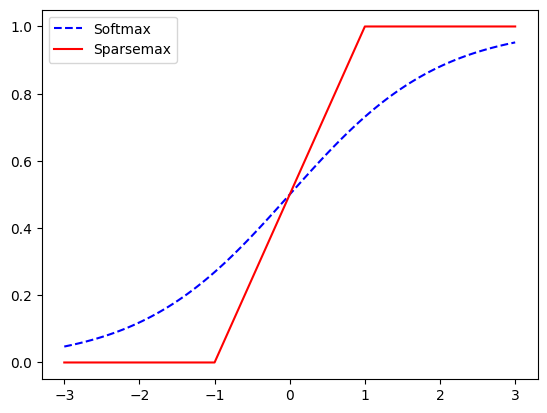

In [9]:
plt.plot(input[:,0].cpu().detach().numpy(), o_soft.cpu().detach().numpy(), label="Softmax", color="blue", linestyle="--")
plt.plot(input[:,0].cpu().detach().numpy(), o_sparse.cpu().detach().numpy(), label="Sparsemax", color="red")
plt.legend();

In [10]:
t1_values = torch.linspace(-3, 3, 50)  # 50 points along t1
t2_values = torch.linspace(-3, 3, 50)  # 50 points along t2
T1, T2 = torch.meshgrid(t1_values, t2_values, indexing="ij")

t1_flat = T1.flatten()
t2_flat = T2.flatten()

input = torch.stack([t1_flat, t2_flat, torch.zeros_like(t1_flat)], dim=1)
o_soft = torch.softmax(input, dim=1)[:,1].view(T1.shape)
o_sparse = sparsemax(input)[:,1].view(T1.shape)

In [11]:
o_soft

tensor([[0.0453, 0.0509, 0.0571,  ..., 0.9374, 0.9442, 0.9503],
        [0.0450, 0.0506, 0.0568,  ..., 0.9370, 0.9439, 0.9500],
        [0.0447, 0.0502, 0.0564,  ..., 0.9366, 0.9435, 0.9497],
        ...,
        [0.0030, 0.0034, 0.0038,  ..., 0.4846, 0.5152, 0.5457],
        [0.0026, 0.0030, 0.0034,  ..., 0.4558, 0.4863, 0.5169],
        [0.0024, 0.0027, 0.0030,  ..., 0.4272, 0.4573, 0.4879]])

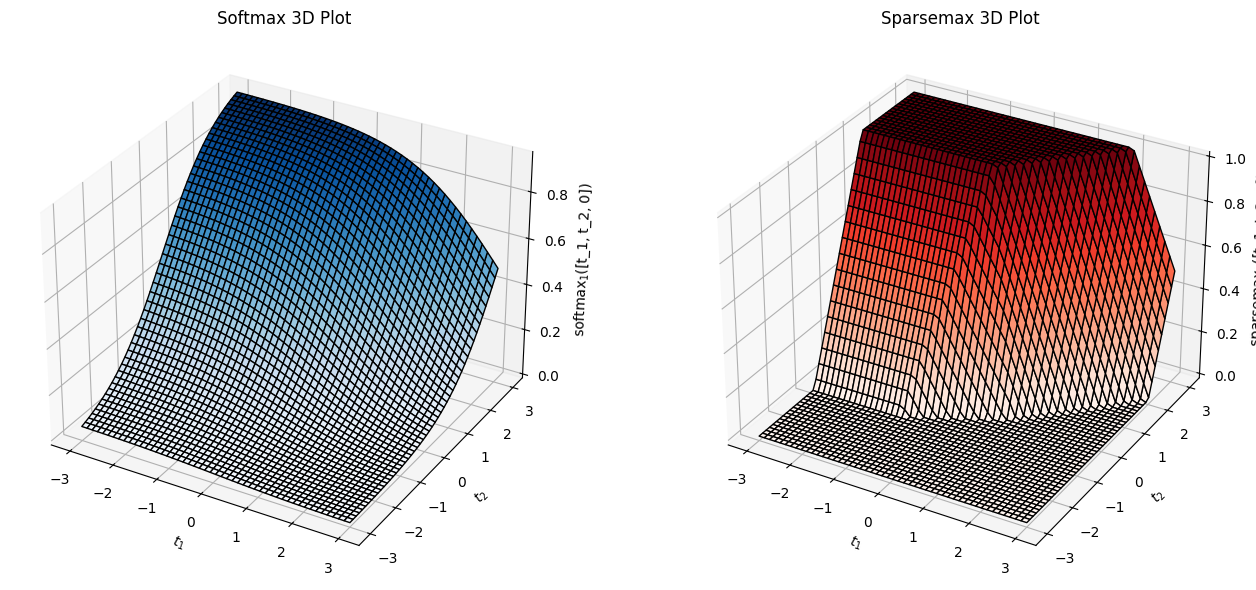

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={"projection": "3d"})

# Softmax Plot
ax1 = axes[0]
ax1.plot_surface(T1.numpy(), T2.numpy(), o_soft.numpy(), cmap='Blues', edgecolor='k')
ax1.set_xlabel(r'$t_1$')
ax1.set_ylabel(r'$t_2$')
ax1.set_zlabel(r'softmax$_1$([t_1, t_2, 0])')
ax1.set_title("Softmax 3D Plot")
# ax1.view_init(elev=30, azim=-120)

# Sparsemax Plot
ax2 = axes[1]
ax2.plot_surface(T1.numpy(), T2.numpy(), o_sparse.numpy(), cmap='Reds', edgecolor='k')
ax2.set_xlabel(r'$t_1$')
ax2.set_ylabel(r'$t_2$')
ax2.set_zlabel(r'sparsemax$_1$([t_1, t_2, 0])')
ax2.set_title("Sparsemax 3D Plot")
# ax2.view_init(elev=30, azim=0)

plt.tight_layout()
plt.show()

In [13]:
from torch.autograd import gradcheck

input = (torch.randn(6, 20, dtype=torch.double,requires_grad=True))
test = gradcheck(sparsemax, input, eps=1e-6, atol=1e-4)
print(test)

True


In [14]:
@dataclass
class Config:
    input_dim: int
    output_dim: int
    n_embd: int
    bn_mini_batch_size: int
    n_blocks_ft: int
    n_blocks_ft_dec: int
    n_decision_steps: int
    n_a: int
    n_d: int
    attn_mask_gamma: float
    lambda_sparse: float
    mask_ratio: float


config = Config(
    input_dim=8,
    output_dim=1,
    n_embd=48,
    bn_mini_batch_size=16,
    n_blocks_ft=4,
    n_blocks_ft_dec=2,
    n_decision_steps=4,
    n_a=16,
    n_d=16,
    attn_mask_gamma=1.0,
    lambda_sparse=0.1,
    mask_ratio=0.3
)

In [15]:
class GLULayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 2*output_dim)

    def forward(self, x):
        x = self.fc(x)
        return F.glu(x, dim=-1)

In [16]:
glu = GLULayer(config.input_dim, config.n_embd)

x = torch.randn(256, config.input_dim)
x_glu = glu(x)
x_glu.shape

torch.Size([256, 48])

In [17]:
print_trainable_parameters(glu)

[GLULayer] Number of trainable parameters: 864 out of 864 total parameters.


In [18]:
class GhostBatchNormalization(nn.Module):
    def __init__(self, input_dim, config):
        super().__init__()

        self.mini_batch_size = config.bn_mini_batch_size
        self.bn = nn.BatchNorm1d(input_dim)

    def forward(self, x):
        n_chunks = int(np.ceil(x.size(0) / self.mini_batch_size))
        chunks = x.chunk(n_chunks, dim=0)
        chunks_norm = [self.bn(chunk) for chunk in chunks]
        return torch.cat(chunks_norm, dim=0)

In [19]:
bn = GhostBatchNormalization(config.input_dim, config)

x = torch.randn(256, config.input_dim)
x_norm = bn(x)
x_norm.shape

torch.Size([256, 8])

In [20]:
print_trainable_parameters(bn)

[GhostBatchNormalization] Number of trainable parameters: 16 out of 16 total parameters.


In [21]:
class FFN(nn.Module):
    def __init__(self, input_dim, output_dim, config):
        super().__init__()

        self.fc = nn.Linear(input_dim, output_dim)
        self.gbn = GhostBatchNormalization(output_dim, config)
        self.glu = GLULayer(output_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        x = self.gbn(x)
        x = self.glu(x)
        return x

In [22]:
ffn = FFN(config.input_dim, config.n_a+config.n_d, config)

x = torch.randn(256, config.input_dim)
x_ffn = ffn(x)
x_ffn.shape

torch.Size([256, 32])

In [23]:
print_trainable_parameters(ffn)

[FFN] Number of trainable parameters: 2,464 out of 2,464 total parameters.


In [24]:
class FeatureTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, config, shared_blocks):
        super().__init__()

        assert config.n_blocks_ft % 2 == 0, "Number of blocks must be even"
        assert len(shared_blocks) == 0 or len(shared_blocks) == config.n_blocks_ft // 2

        self.scale = math.sqrt(0.5)

        if len(shared_blocks) > 0:
            self.shared_blocks = shared_blocks
        else:
            self.shared_blocks = self.build_blocks(input_dim, output_dim, config)

        self.blocks = self.build_blocks(output_dim, output_dim, config)

    def build_blocks(self, input_dim, output_dim, config):
        n_blocks = config.n_blocks_ft//2
        blocks = nn.ModuleList()
        if n_blocks >= 1:
            blocks.append(FFN(input_dim, output_dim, config))

        if n_blocks > 1:
            for _ in range(n_blocks-1):
                blocks.append(FFN(output_dim, output_dim, config))

        return blocks

    def forward(self, x):
        for i,sblock in enumerate(self.shared_blocks):
            if i == 0:
                x = sblock(x)
            else:
                x = x + sblock(x)
                x = x * self.scale

        for block in self.blocks:
            x = x + block(x)
            x = x * self.scale

        return x

In [25]:
ft = FeatureTransformer(config.input_dim, config.n_a+config.n_d, config, [])
x = torch.randn(256, config.input_dim)
x_ft = ft(x)
x_ft.shape

torch.Size([256, 32])

In [26]:
print_trainable_parameters(ft)

[FeatureTransformer] Number of trainable parameters: 12,160 out of 12,160 total parameters.


In [27]:
class AttentiveTransformer(nn.Module):
    def __init__(self, input_dim, config):
        super().__init__()

        self.fc = nn.Linear(config.n_a, input_dim)
        self.gbn = GhostBatchNormalization(input_dim, config)
        self.sparsemax = Sparsemax()

    def forward(self, x, priors):
        x = self.fc(x)
        x = self.gbn(x)
        x = torch.mul(x, priors)
        x = self.sparsemax(x)
        return x

In [28]:
attn = AttentiveTransformer(config.input_dim, config)
x = torch.randn(256, config.n_a)
priors = torch.ones(256, config.input_dim)

x_attn = attn(x, priors)
x_attn.shape

torch.Size([256, 8])

In [29]:
x_attn.numel(), (x_attn > 0.0).float().sum()

(2048, tensor(609.))

In [30]:
print_trainable_parameters(attn)

[AttentiveTransformer] Number of trainable parameters: 152 out of 152 total parameters.


In [31]:
class DecisionStep(nn.Module):
    def __init__(self, input_dim, config, shared_ft_layers):
        super().__init__()

        self.n_d = config.n_d
        self.n_a = config.n_a

        self.attn = AttentiveTransformer(input_dim, config)
        self.feature_transformer = FeatureTransformer(input_dim, self.n_d+self.n_a, config, shared_ft_layers)
        self.relu = nn.ReLU()

    def sparse_loss(self, mask, eps=1e-8):
        loss = (-1.0) * mask * torch.log(mask + eps)
        return loss.sum(dim=-1).mean()

    def forward(self, x, x_a, priors):
        mask = self.attn(x_a, priors)
        sparse_loss = self.sparse_loss(mask)
        x = torch.mul(x, mask)
        x_ft = self.feature_transformer(x)
        x_d, x_a = x_ft[:, :self.n_d], x_ft[:, self.n_d:]
        x_d = self.relu(x_d)
        return x_d, x_a, mask, sparse_loss

In [45]:
ds = DecisionStep(config.input_dim, config, [])
x = torch.randn(256, config.input_dim)
x_a = torch.randn(256, config.n_a)
priors = torch.ones(256, config.input_dim)

x_d, x_a, mask, loss = ds(x, x_a, priors)
x_d.shape, x_a.shape, mask.shape, loss

(torch.Size([256, 16]),
 torch.Size([256, 16]),
 torch.Size([256, 8]),
 tensor(0.6268, grad_fn=<MeanBackward0>))

In [46]:
print_trainable_parameters(ds)

[DecisionStep] Number of trainable parameters: 12,312 out of 12,312 total parameters.


In [33]:
class TabNetEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config
        self.n_a = config.n_a
        self.n_d = config.n_d

        self.init_bn = nn.BatchNorm1d(config.input_dim)
        self.init_feature_transformer = FeatureTransformer(config.input_dim, self.n_d+self.n_a, config, [])


        shared_ft_layers = self.build_shared_blocks(config.input_dim, self.n_d+self.n_a, config)

        self.steps = nn.ModuleList()
        for _ in range(config.n_decision_steps):
            self.steps.append(DecisionStep(config.input_dim, config, shared_ft_layers))

        self.out_proj = nn.Linear(config.n_d, config.n_embd, bias=False)

    def build_shared_blocks(self, input_dim, output_dim, config):
        n_blocks = config.n_blocks_ft//2
        blocks = nn.ModuleList()
        if n_blocks >= 1:
            blocks.append(FFN(input_dim, output_dim, config))

        if n_blocks > 1:
            for _ in range(n_blocks-1):
                blocks.append(FFN(output_dim, output_dim, config))

        return blocks

    def forward(self, x, prior):
        x = self.init_bn(x)
        x_ft = self.init_feature_transformer(x)
        x_a = x_ft[:, self.n_d:]

        out_d = torch.zeros(x.size(0), self.n_d, device=x.device)
        out_a = torch.zeros(x.size(0), self.config.input_dim, device=x.device)
        sparse_loss = torch.tensor(0.0)

        for step in self.steps:
            x_d, x_a, mask, step_sparse_loss = step(x, x_a, prior)
            out_d += x_d
            prior = torch.mul(self.config.attn_mask_gamma - mask, prior)
            sparse_loss += step_sparse_loss

        d_proj = self.out_proj(out_d)

        return d_proj, out_a, sparse_loss

In [34]:
encoder = TabNetEncoder(config)

x = torch.randn(256, config.input_dim)
prior = torch.ones(256, config.input_dim)
d_proj, out_a, loss = encoder(x, prior)
d_proj.shape, out_a.shape, loss

(torch.Size([256, 48]),
 torch.Size([256, 8]),
 tensor(3.1559, grad_fn=<AddBackward0>))

In [47]:
print_trainable_parameters(encoder)

[TabNetEncoder] Number of trainable parameters: 45,104 out of 45,104 total parameters.


In [35]:
class DecoderStep(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.ft = FeatureTransformer(config.n_embd, config.input_dim, config, [])
        self.fc = nn.Linear(config.input_dim, config.input_dim)

    def forward(self, x):
        x = self.ft(x)
        return self.fc(x)

class TabNetDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.steps = nn.ModuleList([DecoderStep(config) for _ in range(config.n_blocks_ft_dec)])
        self.config = config

    def forward(self, x):
        out = torch.zeros(x.size(0), self.config.input_dim, device=x.device)

        for step in self.steps:
            out += step(x)

        return out

In [48]:
ds = DecoderStep(config)

x = torch.randn(256, config.n_embd)
x_dec = ds(x)
x_dec.shape

torch.Size([256, 8])

In [49]:
print_trainable_parameters(ds)

[DecoderStep] Number of trainable parameters: 1,320 out of 1,320 total parameters.


In [37]:
decoder = TabNetDecoder(config)

x = torch.randn(256, config.n_embd)
x_dec = decoder(x)
x_dec.shape

torch.Size([256, 8])

In [50]:
print_trainable_parameters(decoder)

[TabNetDecoder] Number of trainable parameters: 2,640 out of 2,640 total parameters.


In [38]:
class TabNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = TabNetEncoder(config)
        self.decoder = TabNetDecoder(config)

        self.config = config

    def apply_bernoulli_mask(self, x, config):
        mask = torch.bernoulli(torch.empty_like(x).fill_(config.mask_ratio))
        return x * mask, mask

    def forward(self, x):
        x_masked, bin_mask = self.apply_bernoulli_mask(x, self.config)
        prior = 1.0 - bin_mask
        z_d, z_a, sparse_loss = self.encoder(x, prior)
        return self.decoder(z_d), bin_mask

In [39]:
x = torch.randn(256, config.input_dim, device=device)

In [40]:
model = TabNet(config).to(device)

In [41]:
o, mask = model(x)
o.shape, mask.shape

(torch.Size([256, 8]), torch.Size([256, 8]))

In [51]:
print_trainable_parameters(model)

[TabNet] Number of trainable parameters: 47,744 out of 47,744 total parameters.


In [42]:
def reconstruction_loss_fn(x_hat, x, bin_mask):
    norm = ((x - x.mean(dim=0, keepdim=True))**2).sum(dim=0)
    loss = torch.square((x - x_hat) * bin_mask / torch.sqrt(norm))
    return loss.mean()

In [43]:
reconstruction_loss_fn(o, x, mask)

tensor(0.0014, grad_fn=<MeanBackward0>)

In [52]:
x_train = torch.randn((2000*256, config.input_dim), dtype=torch.float32, device=device)

In [53]:
from torch.utils.data import TensorDataset, DataLoader

In [54]:
train_dataset = TensorDataset(x_train)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [55]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [56]:
max_steps = 2000
train_iter = iter(train_dataloader)
for step in range(max_steps):
    model.train(True)

    xb, = next(train_iter)
    xb = xb.to(device)

    xb_hat, bin_mask = model(xb)
    loss = reconstruction_loss_fn(xb_hat, xb, bin_mask)

    optimizer.zero_grad()
    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    if step % 50 == 0:
        print(f"[{model.__class__.__name__}] step {step+1:3d}/{max_steps:3d} | loss={loss.item():.6f} | norm={norm:.4f}")

[TabNet] step   1/2000 | loss=0.001314 | norm=0.0064
[TabNet] step  51/2000 | loss=0.000967 | norm=0.0026
[TabNet] step 101/2000 | loss=0.000725 | norm=0.0054
[TabNet] step 151/2000 | loss=0.000525 | norm=0.0070
[TabNet] step 201/2000 | loss=0.000409 | norm=0.0015
[TabNet] step 251/2000 | loss=0.000243 | norm=0.0016
[TabNet] step 301/2000 | loss=0.000285 | norm=0.0027
[TabNet] step 351/2000 | loss=0.000225 | norm=0.0041
[TabNet] step 401/2000 | loss=0.000200 | norm=0.0013
[TabNet] step 451/2000 | loss=0.000179 | norm=0.0009
[TabNet] step 501/2000 | loss=0.000167 | norm=0.0011
[TabNet] step 551/2000 | loss=0.000142 | norm=0.0007
[TabNet] step 601/2000 | loss=0.000156 | norm=0.0018
[TabNet] step 651/2000 | loss=0.000185 | norm=0.0018
[TabNet] step 701/2000 | loss=0.000189 | norm=0.0012
[TabNet] step 751/2000 | loss=0.000149 | norm=0.0007
[TabNet] step 801/2000 | loss=0.000130 | norm=0.0007
[TabNet] step 851/2000 | loss=0.000145 | norm=0.0008
[TabNet] step 901/2000 | loss=0.000120 | norm=